In [1]:
import openpathsampling as paths
from openpathsampling import adaptive_multilevel_splitting as ams

# Adaptive Multilevel Splitting in OPS

Adaptive multilevel splitting (AMS) is a trajectory-based rare event method that samples trajectories very similar to those sampled by transition interface sampling (TIS). Trajectories must start in the initial state, cross some value of an order parameter $\lambda$, and either end in either the initial state or the final state. However, instead of performing a Monte Carlo in path space, AMS works by maintaining a reservoir of such trajectories. Each trajectory has a maximum value of $\lambda$, and over the set of trajectories in the reservoir, one can find the trajectory with the smallest maximum value. We'll refer to that as the min-max-$\lambda$.

At each step in AMS, the trajectory with the min-max-$\lambda$ is selected to be removed from the reservoir. It is replaced by a new trajectory generated by (1) selecting a random trajectory that will remain in the reservoir, and (2) modifying that trajectory using an interface-constrained shooting move, with the interface set at the old min-max-$\lambda$.

TODO: add links to AMS papers

## Simulation with default AMS setup

OPS provides a simple `DefaultAMS` for the simplest setup of AMS. It can be created with the input:

* `storage`: the file where we store information
* `cv`: the collective variable used as a progress parameter in AMS
* `initial_state`: the initial state
* `final_state`: the final state
* `engine`: a molecular dynamics engine
* `initial_snapshot`: the initial snapshot of the system
* `n_initial_trajectories`: the number of trajectories to keep simultaneously

For simple setups, the initial and final states are entirely defined by values of the CV. However, as with path sampling, a more complicated definition can be used for the states, such as the formation of specific contacts in addition to the generic distance as the CV for the progress parameter. Note, however, that a minimum/maximum value for the max-lambda should always be included in your initial/final state definitions.

In [2]:
# setting up the engine; always the complicated bit
import openpathsampling.engines.toy as toys
import numpy as np

# V(x,y) = x^6 + y^ 6
#          + exp(-0.7 * (12 (x+0.5)^2 + 0.5 y^2))
#          + exp(-0.7 * (12 (x-0.6)^2 + 0.5 y^2))
pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-0.7, [12.0, 0.5], [-0.5, 0.0]) +
       toys.Gaussian(-0.7, [12.0, 0.5], [0.5, 0.0]))

topology = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes)
engine = toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
                      'n_frames_max': 10000,
                      'n_steps_per_frame': 10}, topology)
template = toys.Snapshot(coordinates=np.array([[-0.1, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                         engine=engine)

As usual, we define a CV, and define states based on that CV.

In [3]:
# states are volumes in a CV space: define the CV
def xval(snapshot):
    return snapshot.xyz[0][0]

cv = paths.FunctionCV("xval", xval)

In [4]:
stateA = paths.CVDefinedVolume(cv, float("-inf"), -0.3).named("A")
stateB = paths.CVDefinedVolume(cv, 0.3, float("inf")).named("B")

In [5]:
storage = paths.Storage("toy_ams.nc", 'w', template=template)
storage.save(paths.Trajectory([template]));

`DefaultAMS` will obtain initial trajectories from an initial snapshot. However, this does make several assumptions -- see details below for how to customize an AMS initialization.

In [6]:
sim = ams.DefaultAMS(
    storage=storage,
    initial_state=stateA,
    final_state=stateB,
    cv=cv,
    engine=engine,
    initial_snapshot=template,
    n_initial_trajectories=50
)

In [7]:
%%time
sim.run(n_steps_max=10000)

Replica 13 at -0.2981568175780463 replaced by shot from trajectory in replica 9
Next 4: [(-0.29801541463013065, 32), (-0.2973604943948539, 11), (-0.2959564194779431, 20), (-0.29563394391778014, 42)]
Replica 32 at -0.29801541463013065 replaced by shot from trajectory in replica 35
Next 4: [(-0.2973604943948539, 11), (-0.2959564194779431, 20), (-0.29563394391778014, 42), (-0.295125044148529, 19)]
Replica 11 at -0.2973604943948539 replaced by shot from trajectory in replica 45
Next 4: [(-0.2959564194779431, 20), (-0.29563394391778014, 42), (-0.295125044148529, 19), (-0.2945338719349551, 41)]
Replica 20 at -0.2959564194779431 replaced by shot from trajectory in replica 13
Next 4: [(-0.29563394391778014, 42), (-0.295125044148529, 19), (-0.2945338719349551, 41), (-0.2922702107711146, 33)]
Replica 42 at -0.29563394391778014 replaced by shot from trajectory in replica 4
Next 4: [(-0.295125044148529, 19), (-0.2945338719349551, 41), (-0.2922702107711146, 33), (-0.28680918066687344, 39)]
Replica 

TypeError: '<' not supported between instances of 'Sample' and 'Sample'

In [8]:
sim.sample_set

At this point, we've run the simulation. In the default behavior, 50% of the trajectories we started with have now crossed to the 

In [9]:
storage.close()

## Analysis

As usual with OPS, we first run the simulation, then analyze it. Start by re-opening the file we closed at the end of the simulation phase:

In [10]:
storage = paths.Storage("./toy_ams.nc", mode='r')

First we'll extract the min-max-$\lambda$ associated with each step. In this implementation, that is the min-max-$\lambda$ *before* the step began. We can filter out the missing information from the 0th (initial) step by removing steps where `step.change.details` is `None`.

For convenience in plotting, we'll also get the step number for each step.

In [11]:
stepnum, min_max_lambdas = zip(*[(step.mccycle, step.change.details.min_lambda)
                                 for step in storage.steps if step.change.details is not None])

In AMS, the min-max-$\lambda$ is monotonic-increasing with step number (though not strictly -- successive steps *can* have equal values). The cell with the insert statement belows checks this formally, and the plot after it shows it visually.

In [12]:
for i in range(len(min_max_lambdas) - 1):
    assert min_max_lambdas[i+1] >= min_max_lambdas[i]

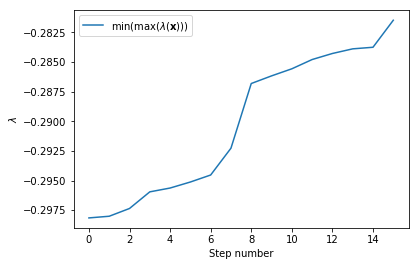

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
steps = [step for step in storage.steps[1:]]
plt.plot(stepnum, min_max_lambdas, label="$\min(\max(\lambda(\mathbf{x})))$")
plt.xlabel("Step number")
plt.ylabel("$\lambda$")
plt.legend();

## Customizing the AMS setup

The default setup is designed to be very simple. However, you can customize many parts of that setup -- in particular, customizing the intialization procedure can be very useful. The main `AdaptiveMultipleSplitting` class takes several options:

* `storage`: as above
* `initial_state`: as above
* `final_state`: as above
* `parametrized_volume`: plays the same role as the CV, but has more flexibility
* `engine`: as above
* `initialization`: how the initial trajectories are obtained

At this point, we don't have many other options for the `parametrized_volume`. It will usually look like this:

In [14]:
parametrized_volume = ams.InterfaceSetParametrizedVolume.from_increasing_cv(cv)

The `DefaultAMS` uses the `DynamicsAMSInitialization` class, which is based on running a single long trajectory to create initial AMS trajectories. For a given `n_trajectories`, the long trajectory runs until it contains `n_trajectories` subtrajectories that can be used as initial conditions for AMS. If the long trajectory fails (because it crossed to the final state), `DynamicsAMSInitialization` will save the trajectories found so far, and restart from the original snapshot.

Note that creating the `DynamicsAMSInitialization` object does not actually run the dynamics, but this is automatically done the first time the `initial_trajectories` attribute is requested.

(TODO: add support for innermost interface to be not equivalent to state -- this is easy from an OPS perspective.)

In [15]:
initialization = ams.DynamicsAMSInitialization(
    initial_state=stateA,
    final_state=stateB,
    n_trajectories=10,
    initial_snapshot=template,
    engine=engine
)
initial_trajectories = initialization.initial_trajectories

If you already have trajectories that you want to use, you can use the generic `AMSInitialization` class. It takes a list of trajectories as input. If you have long trajectories contain subtrajectories that you want to use, you can make use of OPS's `Ensemble.split()` method to turn the long trajectory into a list of subtrajectories satifying the ensemble.

In [16]:
# TODO: implement the thing above

To use your customized initialization, create the simulation with the `AdaptiveMultilevelSplitting` class.

In [17]:
sim = ams.AdaptiveMultilevelSplitting(
    storage=storage,
    initial_state=stateA,
    final_state=stateB,
    parametrized_volume=parametrized_volume,
    engine=engine,
    initialization=initialization
)

From here, you can run and analyze your simulation just like it was done with `DefaultAMS` above.

## Running and analyzing multiple simulations

In practice, you'll usually want to run multiple AMS simulations. For the analysis to work correctly, each simulation should be done with a different instance of the `AdaptiveMultilevelSplitting` object.

Note that `DynamicsAMSInitialization` will only create new trajectories once. If you use the same instance of `DynamicsAMSInitialization` in more than one `AdaptiveMultilevelSplitting` instance, you will use the same initial trajectories. However, this is not recommended. If you want to create use the same trajectories, create the trajectories first and use them as input to an instance of the plain `AMSInitialization`. If you want to create new trajectories for each simulation instance, create new instances of `DynamicsAMSInitialization` for each simulation (which is what will also be done by the `DefaultAMS` factory).

Note that the analysis will work correctly whether you store to the same file or to different files.

In [24]:
sset = storage.samplesets[-2]

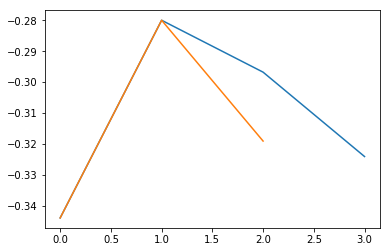

In [27]:
plt.plot(cv(sset[4]))
plt.plot(cv(sset[42]))